In [ ]:
# Dataset
from utils.modules_pbashivan import load_bashivan_data
from utils.modules_pbashivan import get_subject_indices

#Leave one subject cross valdiation
from utils.utils import split_losocv

import numpy as np
import random

# Dataset and Dataloader
from torch.utils.data import TensorDataset, DataLoader


# Save arguments
import argparse

# Torch libraries
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

#CMD:
import itertools
from torch.utils import data

#Model
#from models.model_base import RecResNet
#from losses.cmd import CMD
#from models.model_modules import Extractor, Predictor

#Sklearn
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
import warnings

warnings.simplefilter("ignore")

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--max_iterations', type=int, default=1200)
parser.add_argument('--dir_resume', type=str, default="outputs/resume", help='folder for resume')
parser.add_argument('--batch_size', type=int, default=64, help='batch size')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--seed', type=int, default=223, help='seed')
args = parser.parse_args("")

In [ ]:
# set random seeds
np.random.seed(args.seed)
random.seed(args.seed)
#tf.set_random_seed(args.seed)
print("SEED:", args.seed)

In [ ]:
path = '/home/fer2696/Maestria/Taller Macroentrenamiento IA/Taller_Macroentrenamiento IA/Dataset/'

In [ ]:
# load data
X, y, subjects = load_bashivan_data(path,
                        n_channels=64, n_windows=7, n_bands=3, generate_images=False,
                        size_image=24, visualize=False)


# Model

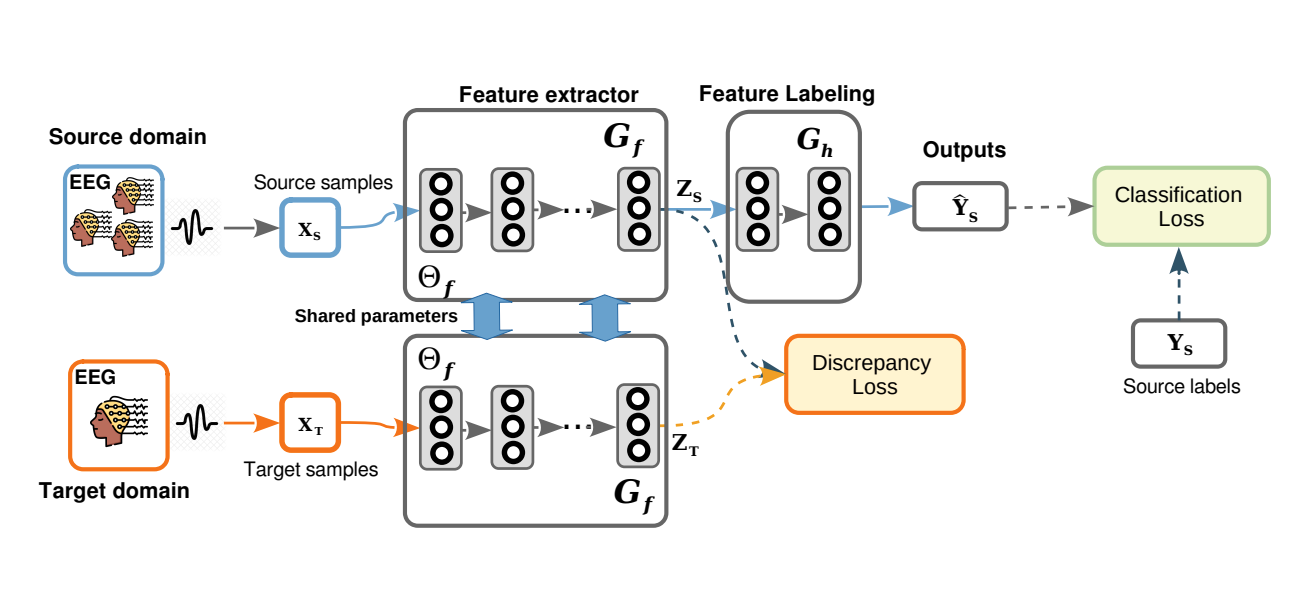

In [ ]:
class Extractor(nn.Module):
    '''
    Feature extractor
    '''

    def __init__(self):
        super(Extractor, self).__init__()

        self.num_layers = 1
        self.hidden_dim = 128

        # Layer 1
        self.conv1 = nn.Conv3d(in_channels=3, out_channels=16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='valid')
        self.bn1 = nn.BatchNorm3d(16, momentum=0.1)

        # Layer 2
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=16, kernel_size=(1, 3, 3), stride=(1, 2, 2), padding='valid')
        self.bn2 = nn.BatchNorm3d(16, momentum=0.1)

        #  Residual block ->
        self.conv3 = nn.Conv3d(in_channels=16, out_channels=16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same')
        self.bn3 = nn.BatchNorm3d(16, momentum=0.1)

        self.conv4 = nn.Conv3d(in_channels=16, out_channels=16, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding='same')
        self.bn4 = nn.BatchNorm3d(16, momentum=0.1)

        # Capa LSTM
        # [32x32 -> 3136]
        # [24x24 -> 1600]
        self.rnn = nn.LSTM(input_size=1600, hidden_size=self.hidden_dim, num_layers=self.num_layers, batch_first=True, dropout=0.5)

        #
        self.fc1 = nn.Linear(128, 128)
        self.drop1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 128)
        self.drop2 = nn.Dropout(p=0.5)

    def forward(self, x):
        # Layer 1
        x = F.relu(self.bn1(self.conv1(x)))

        # Layer 2
        x = F.relu(self.bn2(self.conv2(x)))

        # Residual block
        o = F.relu(self.bn3(self.conv3(x)))
        o = self.bn4(self.conv4(o))
        r = F.relu(x + o)

        # swap axes
        r = torch.swapaxes(r, 1, 2)
        # reshape
        r = torch.reshape(r, (r.shape[0], r.shape[1], r.shape[2] * r.shape[3] * r.shape[4]))
        # RNN
        out, _ = self.rnn(r)
        # reshape
        feats_rnn = out[:, -1]

        feats = F.relu(self.fc1(feats_rnn))
        feats = self.drop1(feats)
        feats = F.relu(self.fc2(feats))
        feats = self.drop2(feats)

        return feats


In [ ]:
class Predictor(nn.Module):
    '''
    Feature labeling module
    '''

    def __init__(self, input_size, n_classes=4):
        super(Predictor, self).__init__()

        self.fc_out = nn.Linear(input_size, n_classes)

    def forward(self, x):
        out = self.fc_out(x)

        return out


# Central Moment Discrepancy (CMD)

CMD propuesto en [Zellinger et al., 2019] reduce los momentos estadísticos de orden mas alto entre las representaciones de características de los dominios fuente y objetivo

In [ ]:

def l2diff(x1, x2):
    """
    standard euclidean norm
    """
    return ((x1-x2)**2).sum().sqrt()


def moment_diff(sx1, sx2, k):
    """
    difference between moments
    """
    ss1 = (sx1**k).mean(0)
    ss2 = (sx2**k).mean(0)
    return l2diff(ss1, ss2)


class CMD(object):
    def __init__(self, n_moments=5):
        self.n_moments = n_moments

    def forward(self, x1, x2):
        mx1 = x1.mean(dim=0)
        mx2 = x2.mean(dim=0)
        sx1 = x1 - mx1
        sx2 = x2 - mx2
        scms = l2diff(mx1.detach(), mx2.detach()) # detach for avoid inplace gradient operation

        for i in range(self.n_moments-1):
            # moment diff of centralized samples
            scms += moment_diff(sx1, sx2, i+2)
        return scms

# Train

## Evaluation function

In [ ]:
def test(network_f, network_h, test_loader):
    start_test = True
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            # get batch data
            samples = data[0].float().cuda()
            labels = data[1].long().cuda()

            # Get features and predictions
            preds = network_h(network_f(samples))
            # probabilidad máxima
            predictions = preds.data.max(1)[1]

            if start_test:
                y_pred = predictions.cpu().numpy()
                y_true = labels.data.cpu().numpy()
                start_test = False
            else:
                y_pred = np.concatenate((y_pred, predictions.cpu().numpy()), 0)
                y_true = np.concatenate((y_true, labels.data.cpu().numpy()), 0)

        # Binarize ytest with shape (n_samples, n_classes)
        labels = np.unique(y_true)
        ytest = label_binarize(y_true, classes=labels)
        ypreds = label_binarize(y_pred, classes=labels)

        # compute utils
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        auc = roc_auc_score(ytest, ypreds, average='macro', multi_class='ovr')


    return acc, f1, auc

In [ ]:
def losocv(X, Y, subjects, args):
    """
        Leave One-Subject-Out Cross-Validation (LOOCV) on Cognitive Load data

        Params
            X: dataset containing all subject samples
            Y: dataset containing all subject labels
            subjects: dataset containing pairs between sample indexes and subjects
            args: hyper-parameters to train Custom Domain Adaptation.
    """

    # variable used to save accuracy results
    list_metrics_clsf = []
        
    # Extract pairs between indexes and subjects
    fold_pairs = get_subject_indices(subjects)
    
    # Iterate over fold_pairs
    for foldNum, fold in enumerate(fold_pairs):
        print('Beginning fold {0} out of {1}'.format(foldNum+1, len(fold_pairs)))

        # Only Subjects 1, 2 are executed
        if foldNum + 1 >= 3:# and foldNum + 1 <= 11:
            continue

        # Get source and target datasets
        (x_src, y_src), (x_trg, y_trg), y_classes = split_losocv(X, Y, fold)

        # data shape
        print("x_src-shape:", x_src.shape, "y_src-shape:", y_src.shape)
        print("x_trg-shape:", x_trg.shape, "y_trg-shape:", y_trg.shape)
        print("classes:", y_classes)

        # [NUMPY TO TENSOR]
        Sx_tensor = torch.tensor(x_src)
        Sy_tensor = torch.tensor(y_src)
        Tx_tensor = torch.tensor(x_trg)
        Ty_tensor = torch.tensor(y_trg)

        # [CONTAINERS]
        # create container for source labeled data
        source = TensorDataset(Sx_tensor, Sy_tensor)
        # create container for labeled target data
        target = TensorDataset(Tx_tensor, Ty_tensor)

        # [BUILD DATA LOADERS]
        # target
        source_loader = DataLoader(source, batch_size=args.batch_size, shuffle=True, num_workers=4, drop_last=True)
        target_loader = DataLoader(target, batch_size=args.batch_size, shuffle=True, num_workers=4, drop_last=True)
        test_loader = DataLoader(target, batch_size=args.batch_size, shuffle=False, num_workers=4)

        # counter
        epoch = 1
        eval_iter = x_src.shape[0] // args.batch_size # evaluate each 'eva_iter'

        # [Build Model]
        hidden_size = 128
        network_f = Extractor().cuda()
        network_h = Predictor(input_size=hidden_size, n_classes=4).cuda()

        # [OPTIMIZERS]
        optimizer_f = optim.Adam(network_f.parameters(), lr=args.lr, weight_decay=0.0001)
        optimizer_h = optim.Adam(network_h.parameters(), lr=args.lr, weight_decay=0.0001)

        # [Classification loss]
        criterion = nn.CrossEntropyLoss().cuda()

        # [Central moment Discrepancy]
        cmd_loss = CMD(n_moments=2)

        # length of datasets
        len_train_source = len(source_loader)
        len_train_target = len(target_loader)

        # Almacenar pérdida
        list_loss = []

        for iter_num in range(0, args.max_iterations + 1):
            network_f.train()
            network_h.train()

            # Update loaders
            if iter_num % len_train_source == 0:
                data_iter_s = iter(source_loader)
            if iter_num % len_train_target == 0:
                data_iter_t = iter(target_loader)

            # get batch
            inputs_target, _ = next(data_iter_t)
            inputs_source, labels_source = next(data_iter_s)

            # TO CUDA
            inputs_source, inputs_target, labels_source = inputs_source.float().cuda(), inputs_target.float().cuda(), labels_source.long().cuda()

            # extract features and outputs
            # Source domain
            features_source = network_f(inputs_source)
            outputs_source = network_h(features_source)

            # Target domain
            features_target = network_f(inputs_target)


            # [CMD Loss]
            transfer_loss = cmd_loss.forward(features_source, features_target)

            # [Classification Loss]
            classifier_loss = criterion(outputs_source, labels_source)

            # [Total loss]
            lambda_dis = 1.0
            total_loss = classifier_loss + lambda_dis * transfer_loss

            # Reset gradients
            optimizer_f.zero_grad()  # feature extractor
            optimizer_h.zero_grad()  # classifier

            # Barckpropagation
            total_loss.backward()

            # Update weights
            optimizer_f.step()
            optimizer_h.step()


            # append loss
            list_loss.append(total_loss.cpu().detach().numpy())

            # [EVALUATION]
            if iter_num % int(eval_iter) == 0 and iter_num > 0:
                network_f.eval()
                network_h.eval()
                acc, f1, auc = test(network_f, network_h, test_loader)

                avg_loss = np.array(list_loss).mean()
                print('Epoch: %d loss: %4f Acc: %.4f  F1-score: %.4f  AUC: %.4f' % (epoch, avg_loss, acc, f1, auc))
                epoch += 1


        print("\n")
        # add to list
        list_metrics_clsf.append([acc, f1, auc, foldNum+1])
    
    # To np array
    list_metrics_clsf = np.array(list_metrics_clsf)

    # Save Classification Metrics
    save_file = args.dir_resume+"/losocv-results.csv"
    f=open(save_file, 'ab')
    np.savetxt(f, list_metrics_clsf, delimiter=",", fmt='%0.4f')
    f.close()

In [ ]:
# run Leave One-Subject-Out Cross-Validation (LOSOCV).
losocv(X, y, subjects, args)

## Open results in csv

In [ ]:
import pandas as pd

df = pd.read_csv(args.dir_resume + "/losocv-results.csv")
print(df.to_string()) 